# Analysis LA county Accidents data

Credit to https://smoosavi.org/datasets/us_accidents

(Note: an unexpected problem is, I didn't find the data in 2018 from the national dataset)

Load the python tools needed

In [1]:
import pandas as pd
import folium
import json
from folium import plugins
import matplotlib.pyplot as plt 

In [2]:
with open('laMap.geojson') as f:
    laArea = json.load(f)

In [3]:
df = pd.read_csv("US_Accidents_Dec20_updated_LA.csv")

In [4]:
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2721958,2,22/03/2016 19:14,23/03/2016 01:14,33.91133,-118.16819,33.91585,-118.18840,1.200,At I-710/Garfield Ave - Accident.,...,False,False,False,False,False,False,Night,Day,Day,Day
1,A-2721959,2,22/03/2016 19:43,23/03/2016 01:43,33.89238,-118.04408,33.89494,-118.04882,0.324,At Carmenita Rd/Exit 119 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
2,A-2721960,2,22/03/2016 19:36,23/03/2016 01:36,34.09256,-118.20622,34.09256,-118.20622,0.000,At Avenue 43 - Accident.,...,False,False,True,False,False,False,Night,Night,Day,Day
3,A-2721961,2,22/03/2016 20:12,23/03/2016 02:12,33.91619,-118.23915,33.91619,-118.23903,0.007,At Wilmington Ave - Accident.,...,False,False,False,False,True,False,Night,Night,Night,Day
4,A-2721962,2,22/03/2016 20:12,23/03/2016 02:12,33.91619,-118.23903,33.91619,-118.23915,0.007,At Wilmington Ave - Accident.,...,False,False,False,False,True,False,Night,Night,Night,Day


In [5]:
df.isna().any()

ID                       False
Severity                 False
Start_Time               False
End_Time                 False
Start_Lat                False
Start_Lng                False
End_Lat                  False
End_Lng                  False
Distance(mi)             False
Description              False
Number                    True
Street                   False
Side                     False
City                      True
County                   False
State                    False
Zipcode                  False
Country                  False
Timezone                 False
Airport_Code             False
Weather_Timestamp         True
Temperature(F)            True
Wind_Chill(F)             True
Humidity(%)               True
Pressure(in)              True
Visibility(mi)            True
Wind_Direction            True
Wind_Speed(mph)           True
Precipitation(in)         True
Weather_Condition         True
Amenity                  False
Bump                     False
Crossing

# 1. Clean used data

In [6]:
df['clean_Start_Time'] = pd.to_datetime(df['Start_Time'], format = '%d/%m/%Y %H:%M', errors = 'coerce')

# Clean the Start_time and create a new column for only "year"

In [7]:
df['Year'] = df['clean_Start_Time'].dt.year

In [8]:
df['Year']

0        2016.0
1        2016.0
2        2016.0
3        2016.0
4        2016.0
          ...  
90715    2019.0
90716    2019.0
90717    2019.0
90718    2019.0
90719    2019.0
Name: Year, Length: 90720, dtype: float64

In [9]:
df.clean_Start_Time

0       2016-03-22 19:14:00
1       2016-03-22 19:43:00
2       2016-03-22 19:36:00
3       2016-03-22 20:12:00
4       2016-03-22 20:12:00
                ...        
90715   2019-12-10 16:58:00
90716   2019-12-10 16:53:00
90717   2019-12-10 16:57:00
90718   2019-12-10 16:56:00
90719   2019-12-10 17:02:00
Name: clean_Start_Time, Length: 90720, dtype: datetime64[ns]

In [10]:
df['clean_End_Time'] = pd.to_datetime(df['End_Time'], format = '%d/%m/%Y %H:%M', errors = 'coerce')

# Clean the End_time

In [11]:
df.End_Time

0        23/03/2016 01:14
1        23/03/2016 01:43
2        23/03/2016 01:36
3        23/03/2016 02:12
4        23/03/2016 02:12
               ...       
90715    10/12/2019 18:10
90716    10/12/2019 17:48
90717    10/12/2019 17:50
90718    10/12/2019 17:27
90719    10/12/2019 17:55
Name: End_Time, Length: 90720, dtype: object

In [12]:
df_aircondition = df[["Temperature(F)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)"]].dropna(how='any')

# Create a subset for 4 weather conditions (temperature/pressure/visibility/wind speed) about accidents

In [13]:
df_aircondition

,Temperature(F),Pressure(in),Visibility(mi),Wind_Speed(mph)
0,63.0,30.00,10.0,12.7
1,63.0,29.97,10.0,5.8
2,64.0,30.00,10.0,9.2
3,62.1,30.02,10.0,5.8
4,62.1,30.02,10.0,5.8
...,...,...,...,...
90715,61.0,30.12,10.0,3.0
90716,64.0,29.98,10.0,0.0
90717,63.0,30.07,10.0,5.0
90718,63.0,30.07,10.0,5.0


# 2. Basic analysis

2.1 How many cases are there in LA county from 2016-2020 (except 2018)?

In [14]:
len(df)

90720

2.2 The number of traffic accidents in 4 different severity in these 4 years

In [15]:
df.Severity.value_counts()

2    85629
3     3805
4     1285
1        1
Name: Severity, dtype: int64

In [16]:
df.Severity.value_counts(normalize=True).round(4) * 100

2    94.39
3     4.19
4     1.42
1     0.00
Name: Severity, dtype: float64

2.3 The description about distance affected by traffic jam in these four years

In [17]:
round(df["Distance(mi)"].mean(),2)

0.33

In [18]:
round(df["Distance(mi)"].max(),2)

137.62

In [19]:
round(df["Distance(mi)"].min(),2)

0.0

2.4 The description about 4 weather conditions which may affect traffic jam in these four years

In [20]:
df_aircondition.agg(['min', 'max', 'mean']).round(2).reset_index()

,index,Temperature(F),Pressure(in),Visibility(mi),Wind_Speed(mph)
0,min,23.00,3.04,0.00,0.0
1,max,111.90,32.87,25.00,822.8
2,mean,63.64,29.62,9.03,5.0


# 3. Analysis based on "time"

3.1 The Average traffic delay(hours) due to road accidents

In [21]:
df['duration_time_hour'] = (df['clean_End_Time'] - df['clean_Start_Time']).dt.seconds/60/60

In [22]:
df['duration_time_hour'] = round(df['duration_time_hour'])

In [23]:
df['duration_time_hour']

0        6.0
1        6.0
2        6.0
3        6.0
4        6.0
        ... 
90715    1.0
90716    1.0
90717    1.0
90718    1.0
90719    1.0
Name: duration_time_hour, Length: 90720, dtype: float64

In [24]:
df.duration_time_hour.max()

24.0

In [25]:
df.duration_time_hour.min()

0.0

In [26]:
round(df.duration_time_hour.mean(), 2)

3.13

3.2 Average time spent in traffic jams per year

In [27]:
df_2016 = df[df["Start_Time"].str.contains("2016")]

In [28]:
df['duration_time_hour2016'] = round((df_2016['clean_End_Time'] - df_2016['clean_Start_Time']).dt.seconds/60/60)

In [29]:
df_2017 = df[df["Start_Time"].str.contains("2017")]

In [30]:
df['duration_time_hour2017'] = round((df_2017['clean_End_Time'] - df_2017['clean_Start_Time']).dt.seconds/60/60)

In [31]:
df_2019 = df[df["Start_Time"].str.contains("2019")]

In [32]:
df['duration_time_hour2019'] = round((df_2019['clean_End_Time'] - df_2019['clean_Start_Time']).dt.seconds/60/60)

In [33]:
df_2020 = df[df["Start_Time"].str.contains("2020")]

In [34]:
df['duration_time_hour2020'] = round((df_2020['clean_End_Time'] - df_2020['clean_Start_Time']).dt.seconds/60/60)

In [35]:
duration_2016 = round(df['duration_time_hour2016'].mean(),2)

In [36]:
duration_2017 = round(df['duration_time_hour2017'].mean(),2)

In [37]:
duration_2019 = round(df['duration_time_hour2019'].mean(),2)

In [38]:
duration_2020 = round(df['duration_time_hour2020'].mean(),2)

In [39]:
duration_average = {"Year":[2016,2017,2019,2020],
                    "average_duration_time":[duration_2016, duration_2017, duration_2019, duration_2020]}
duration_average_year = pd.DataFrame(duration_average)
duration_average_year

,Year,average_duration_time
0,2016,6.01
1,2017,6.00
2,2019,1.47
3,2020,2.35


<AxesSubplot:xlabel='Year'>

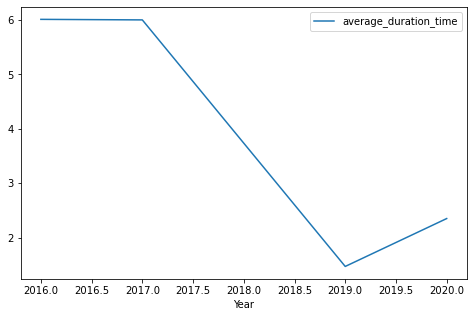

In [40]:
duration_average_year.plot(kind='line', x="Year", y="average_duration_time", figsize=(8,5))

3.3 The average number of car accidents per day per yearThe average number of car accidents per day per year

In [41]:
Year_df = pd.DataFrame(df.clean_Start_Time.dt.year.value_counts()).reset_index().rename(columns={'index':'Year', 'clean_Start_Time':'Cases'}).sort_values(by='Cases', ascending=False)

In [42]:
Year_df['accident/day'] = round(Year_df['Cases']/365)

In [43]:
Year_df

,Year,Cases,accident/day
0,2020.0,63802,175.0
1,2016.0,11802,32.0
2,2017.0,8224,23.0
3,2019.0,4507,12.0


3.4 The number of 4 type(classified by Severity) car accidents per year

In [44]:
df.groupby(['Year', 'Severity']).size().unstack()

Severity,1,2,3,4
Year,,,,
2016.0,NaN,9923.0,1515.0,364.0
2017.0,NaN,6930.0,1014.0,280.0
2019.0,NaN,4447.0,26.0,34.0
2020.0,1.0,61947.0,1250.0,604.0


In [45]:
df_year = df.groupby(['Year', 'Severity']).size().unstack()

<AxesSubplot:ylabel='Year'>

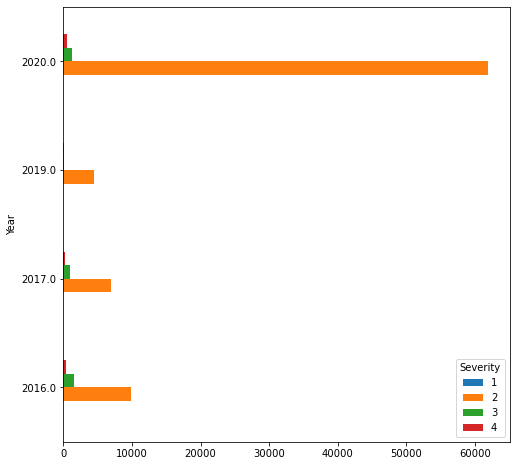

In [46]:
df_year.plot(kind='barh', xlabel="Year", ylabel="Severity", figsize=(8,8))

# 4. Analysis based on "location"

4.1 Top ten cities with the highest cases in LA county

In [47]:
city_df = pd.DataFrame(df['City'].value_counts()).reset_index().rename(columns={'index':'City', 'City':'Cases'})

# The number of traffic accidents in different cities

In [48]:
city_df.head(5)

,City,Cases
0,Los Angeles,26699
1,Long Beach,3660
2,Whittier,2603
3,Baldwin Park,1930
4,Pomona,1787


4.2 Top ten street with the highest cases in LA county

In [49]:
df.Street.value_counts().head(5).reset_index()

# The number of traffic accidents in different streets

,index,Street
0,I-10 W,3701
1,I-10 E,3700
2,I-405 N,3368
3,Golden State Fwy S,2574
4,I-405 S,2164


4.3 A hot point map based on the starting point of a traffic accident

In [50]:
laMap = folium.Map(location=[34.0522,-118.2437], tiles='Stamen Toner', zoom_start=9)

In [51]:
folium.GeoJson(laArea).add_to(laMap)

In [52]:
for i,row in df.iterrows():
    folium.CircleMarker((row.Start_Lat,row.Start_Lng), radius=1, weight=1, color='red', fill_color='red', fill_opacity=.5).add_to(laMap)

In [53]:
laMap.save('laPointMap_accident.html')
# html file please see in the folder

# 5. Analysis basd on road and driving condition

5.1 Traffic accidents occurred on the relative side of the street

In [54]:
df.Side.value_counts()

R    81714
L     9006
Name: Side, dtype: int64

In [55]:
df.Side.value_counts(normalize=True).round(4) * 100

R    90.07
L     9.93
Name: Side, dtype: float64

5.2 The number of traffic accidents in different weather conditions

In [56]:
df["Weather_Condition"].dropna(how='any')

# cleaning the null data in "Weather_Condition"

0         Clear
1         Clear
2         Clear
3         Clear
4         Clear
          ...  
90715    Cloudy
90716    Cloudy
90717    Cloudy
90718    Cloudy
90719    Cloudy
Name: Weather_Condition, Length: 87688, dtype: object

In [57]:
df.Weather_Condition.value_counts().head(10)

Fair                43178
Clear               12136
Cloudy               7669
Mostly Cloudy        5575
Partly Cloudy        5118
Light Rain           3360
Haze                 3085
Overcast             2297
Rain                 1548
Scattered Clouds      903
Name: Weather_Condition, dtype: int64

In [58]:
pd.value_counts(df.Weather_Condition, normalize=True).head(10).round(4) * 100

Fair                49.24
Clear               13.84
Cloudy               8.75
Mostly Cloudy        6.36
Partly Cloudy        5.84
Light Rain           3.83
Haze                 3.52
Overcast             2.62
Rain                 1.77
Scattered Clouds     1.03
Name: Weather_Condition, dtype: float64

5.3 Probability of car accidents in different humidity conditions (based on the number of car accidents in different humidity conditions)

In [59]:
df["Humidity(%)"].dropna(how='any')

# cleaning the null data in "Humidity(%)"

0        58.0
1        50.0
2        24.0
3        56.0
4        56.0
         ... 
90715    72.0
90716    70.0
90717    67.0
90718    67.0
90719    70.0
Name: Humidity(%), Length: 87473, dtype: float64

In [60]:
df["Humidity(%)"].value_counts()

83.0    2179
78.0    2041
75.0    2035
72.0    1985
80.0    1983
        ... 
98.0       4
3.0        3
99.0       2
91.0       2
95.0       1
Name: Humidity(%), Length: 98, dtype: int64

In [61]:
bins = [0,10,20,30,40,50,60,70,80,90,100]

In [62]:
df_Humidity = pd.cut(df["Humidity(%)"], bins)

In [63]:
pd.value_counts(df_Humidity)

(70, 80]     13590
(60, 70]     13546
(50, 60]     12473
(80, 90]     12044
(40, 50]      9618
(30, 40]      8198
(20, 30]      6579
(10, 20]      5964
(90, 100]     3586
(0, 10]       1875
Name: Humidity(%), dtype: int64

In [64]:
df_Humidity_scope = pd.value_counts(df_Humidity, normalize=True).round(2) * 100

In [65]:
df_Humidity_scope

(70, 80]     16.0
(60, 70]     15.0
(50, 60]     14.0
(80, 90]     14.0
(40, 50]     11.0
(30, 40]      9.0
(20, 30]      8.0
(10, 20]      7.0
(90, 100]     4.0
(0, 10]       2.0
Name: Humidity(%), dtype: float64

In [66]:
df_Humidity_scope.reset_index().rename(columns={'index':'Humidity_scope', 'Humidity(%)':'Cases%'}).sort_values(by=['Humidity_scope'])

,Humidity_scope,Cases%
9,"(0, 10]",2.0
7,"(10, 20]",7.0
6,"(20, 30]",8.0
5,"(30, 40]",9.0
4,"(40, 50]",11.0
2,"(50, 60]",14.0
1,"(60, 70]",15.0
0,"(70, 80]",16.0
3,"(80, 90]",14.0
8,"(90, 100]",4.0


In [67]:
df_Humidity_scope_picture = df_Humidity_scope.reset_index().rename(columns={'index':'Humidity_scope', 'Humidity(%)':'Cases%'}).sort_values(by=['Humidity_scope'])

<AxesSubplot:xlabel='Humidity_scope'>

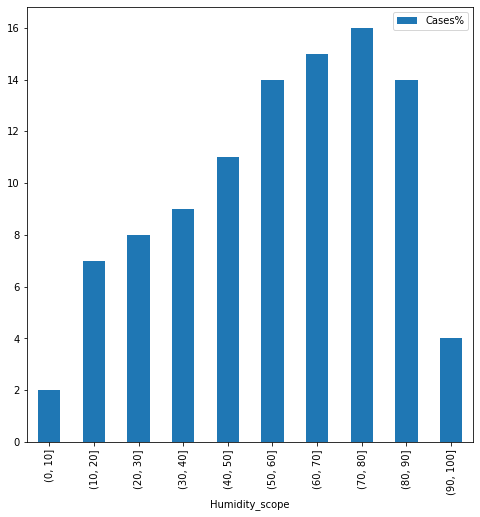

In [68]:
df_Humidity_scope_picture.plot(kind='bar', x="Humidity_scope", y='Cases%',figsize=(8,8))

5.4 The probability of a car accident in different visibility

In [69]:
df["Visibility(mi)"].dropna(how='any')

# cleaning the null data in "Humidity(%)"

0        10.0
1        10.0
2        10.0
3        10.0
4        10.0
         ... 
90715    10.0
90716    10.0
90717    10.0
90718    10.0
90719    10.0
Name: Visibility(mi), Length: 87583, dtype: float64

In [70]:
df["Visibility(mi)"].agg(['min', 'max', 'median', 'mean']).round(2).reset_index()

,index,Visibility(mi)
0,min,0.0
1,max,25.0
2,median,10.0
3,mean,9.0


In [71]:
bins = [0,1,2,3,4,5,6,7,8,9,10,25]

In [72]:
df_Visibility = pd.cut(df["Visibility(mi)"], bins)

In [73]:
pd.value_counts(df_Visibility)

(9, 10]     67014
(8, 9]       3366
(6, 7]       3285
(7, 8]       2949
(5, 6]       2336
(4, 5]       2211
(3, 4]       1809
(1, 2]       1713
(2, 3]       1610
(0, 1]       1248
(10, 25]       13
Name: Visibility(mi), dtype: int64

In [74]:
df_Visibility_scope = pd.value_counts(df_Visibility, normalize=True).round(4) * 100

In [75]:
df_Visibility_scope.reset_index().rename(columns={'index':'Visibility_scope', 'Visibility(mi)':'Cases%'}).sort_values(by=['Visibility_scope'])

,Visibility_scope,Cases%
9,"(0, 1]",1.43
7,"(1, 2]",1.96
8,"(2, 3]",1.84
6,"(3, 4]",2.07
5,"(4, 5]",2.53
4,"(5, 6]",2.67
2,"(6, 7]",3.75
3,"(7, 8]",3.37
1,"(8, 9]",3.84
0,"(9, 10]",76.54


In [76]:
df_Visibility_scope_picture = df_Visibility_scope.reset_index().rename(columns={'index':'Visibility_scope', 'Visibility(mi)':'Cases%'}).sort_values(by=['Visibility_scope'])

<AxesSubplot:xlabel='Visibility_scope'>

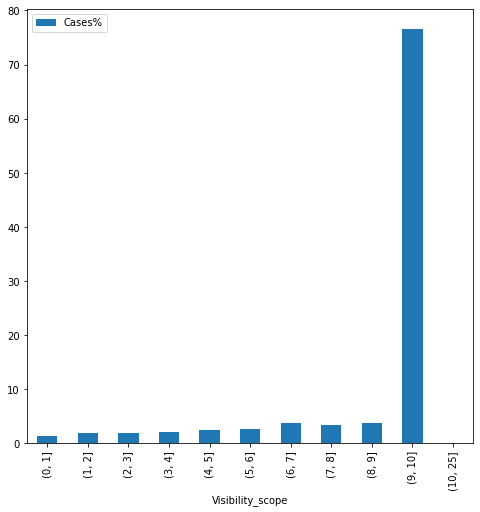

In [77]:
df_Visibility_scope_picture.plot(kind='bar', x="Visibility_scope", y='Cases%',figsize=(8,8))